In [1]:
import pandas as pd
import numpy as np
#import matplotlib
import matplotlib.pyplot as  plt
import matplotlib.dates as mdates
#import seaborn as sns
import requests
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
import calendar

plt.style.use('seaborn-whitegrid')

In [17]:
def get_telemetrica(codEstacao, dataInicio, dataFim, save=False):
    
    # 1. Fazer a requisião ao servidor e pegar a árvore e a raiz dos dados 
    params = {'codEstacao':codEstacao, 'dataInicio':dataInicio, 'dataFim':dataFim}
    server = 'http://telemetriaws1.ana.gov.br/ServiceANA.asmx/DadosHidrometeorologicos'
    response = requests.get(server, params)
    tree = ET.ElementTree(ET.fromstring(response.content))
    root = tree.getroot()

    # 2. Iteração dentro dos elementos do XML procurando os dados que são disponibilizados para a estação
    list_vazao = []
    list_data = []
    list_nivel = []
    list_chuva = []

    for i in root.iter('DadosHidrometereologicos'):

        data = i.find('DataHora').text
        try:
            vazao = float(i.find('Vazao').text)
        except TypeError:
            vazao = i.find('Vazao').text

        try:
            nivel = float(i.find('Nivel').text)
        except TypeError:
            nivel = i.find('Nivel').text

        try:
            chuva = float(i.find('Chuva').text)
        except TypeError:
            chuva = i.find('Chuva').text

        list_vazao.append(vazao)
        list_data.append(data)
        list_nivel.append(nivel)
        list_chuva.append(chuva)
    df = pd.DataFrame([list_data,list_nivel,list_chuva, list_vazao]).transpose()
    df.columns = ['Data','Nível','Chuva','Vazão']
    df = df.sort_values(by='Data')
    df = df.set_index('Data')
    
    if save == True:
        df.to_excel(codEstacao+'_dados.xlsx')
    
    return df


def get_convencional(codEstacao, dataInicio, dataFim, tipoDados, nivelConsistencia, save=False):

    # 1. Fazer a requisião ao servidor e pegar a árvore e a raiz dos dados 
    params = {'codEstacao':codEstacao, 'dataInicio':dataInicio, 'dataFim':dataFim,
              'tipoDados':tipoDados, 'nivelConsistencia':nivelConsistencia}
    
    server = 'http://telemetriaws1.ana.gov.br/ServiceANA.asmx/HidroSerieHistorica'
    response = requests.get(server, params)
    tree = ET.ElementTree(ET.fromstring(response.content))
    root = tree.getroot()
    
    # 2. Iteração dentro dos elementos do XML procurando os dados que são disponibilizados para a estação
    list_data = []
    list_consistenciaF = []
    list_month_dates = []

    for i in root.iter('SerieHistorica'):

        consistencia = i.find('NivelConsistencia').text
        date = i.find('DataHora').text
        #date = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        last_day = calendar.monthrange(date.year, date.month)[1]
        month_dates = [date + timedelta(days=i) for i in range(last_day)]
        content = []
        list_consistencia = []

        for day in range(last_day):

            if tipoDados == 3:
                value = f'Vazao{day+1:02d}'
            if tipoDados == 2:
                value = f'Chuva{day+1:02d}'
            
            try:
                content.append(float(i.find(value).text))
                list_consistencia.append(int(consistencia))
            except TypeError:
                content.append(i.find(value).text)
                list_consistencia.append(int(consistencia))
            except AttributeError:
                content.append(None)
                list_consistencia.append(int(consistencia))
        
        list_data += content
        list_consistenciaF += list_consistencia
        list_month_dates += month_dates
    df = pd.DataFrame([list_month_dates,list_consistenciaF,list_data]).transpose()

    if tipoDados == 3:
        df.columns = ['Data','Consistência','Vazao']
    elif tipoDados == 2:
        df.columns = ['Data','Consistência','Chuva']
    
    df = df.sort_values(by='Data')
    df = df.set_index('Data')
    
    return df

def hidrograma(df, save=False, outname=''):
    
    fig,axs=plt.subplots(figsize=(13,7))
    
    Q = df['Vazao'].values
    #pcp = df['Chuva'].values
    ax2=axs.twinx()
    axs.get_shared_x_axes().join(ax2)
    
    axs.plot(df.index, Q, color='green', label='Vazão')
             
    #ax2.bar(df.index, -pcp, color='dodgerblue', width=0.1, linewidth=0, label='Precipitação')
         
    axs.set_zorder(2)
    ax2.set_zorder(1)
    ax2.patch.set_visible(True)
    axs.patch.set_visible(False)

    # consertar sinal do eixo y da precipitação
    #maximum_prec = max(pcp)
    #y2_ticks =  np.round(np.arange(0, maximum_prec, step=maximum_prec/6),2)
    #y2_ticklabels = [str(i) for i in y2_ticks]
    #ax2.set_yticks(-1*y2_ticks)
    #ax2.set_yticklabels(y2_ticklabels)
    #axs.set_xlabel('tempo', fontweight='bold')
    #axs.set_ylabel('Q (m³/s)', fontweight='bold')
    #ax2.set_ylabel('Precipitação (mm)', fontweight='bold')


    axs.grid(True,linestyle=':')

    axs.tick_params(axis='x', rotation=90)
    ax2.tick_params(axis='x', rotation=90)
    
    axs.legend(frameon=True,bbox_to_anchor=(.22,1.13))
    ax2.legend(frameon=True,bbox_to_anchor=(.23,0.99))
    
    

    fig.tight_layout()
    if save==True:
        plt.savefig('./figuras/hidrograma_'+outname+'.jpg', dpi=300)

In [18]:
#estTel = pd.read_excel('All_telemetricas_BPS_cod.xlsx')

In [19]:
estTel = estTel.loc[estTel['NomeRio']=='RIO JAGUARI']

In [27]:
dic_Q = {}

#estacoes = estTel.CodEstacao

estacoes = ['58116900', '58128100', '58128200', '58115900', '58116500', '58117000', '58117400', '58140200']

for estacao in estacoes:
    dic_Q[estacao] = get_convencional(codEstacao = estacao, dataInicio = '01/01/2001', dataFim = '01/01/2021', tipoDados=3, nivelConsistencia=2, save=False)

#    dic_Q[estacao] = get_telemetrica(codEstacao = estacao, dataInicio = '01/01/2022', dataFim = '25/01/2022', save=False)

#estacao = '58235100'

#dic_Q[estacao] = get_telemetrica(codEstacao = estacao, dataInicio = '01/01/2017', dataFim = '01/01/2022', save=False)
#dic_Q[estacao] = get_convencional(codEstacao = estacao, dataInicio = '01/01/2002', dataFim = '01/01/2022', tipoDados=3, nivelConsistencia=2, save=False)

In [28]:
df_join = pd.concat(dic_Q)
df_join.to_excel('dados.xlsx')

# Plotar hidrograma

In [22]:
#estacao = estacoes.to_list()[0]

my_list = pd.date_range(start ='01/01/2001' ,end ='01/01/2021' , freq='30min')
dic_Q[estacao].index = pd.to_datetime(dic_Q[estacao].index)
df_filtro  = dic_Q[estacao][dic_Q[estacao].index.isin(my_list)]

TypeError: Cannot convert Float64Index to dtype datetime64[ns]; integer values are required for conversion

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


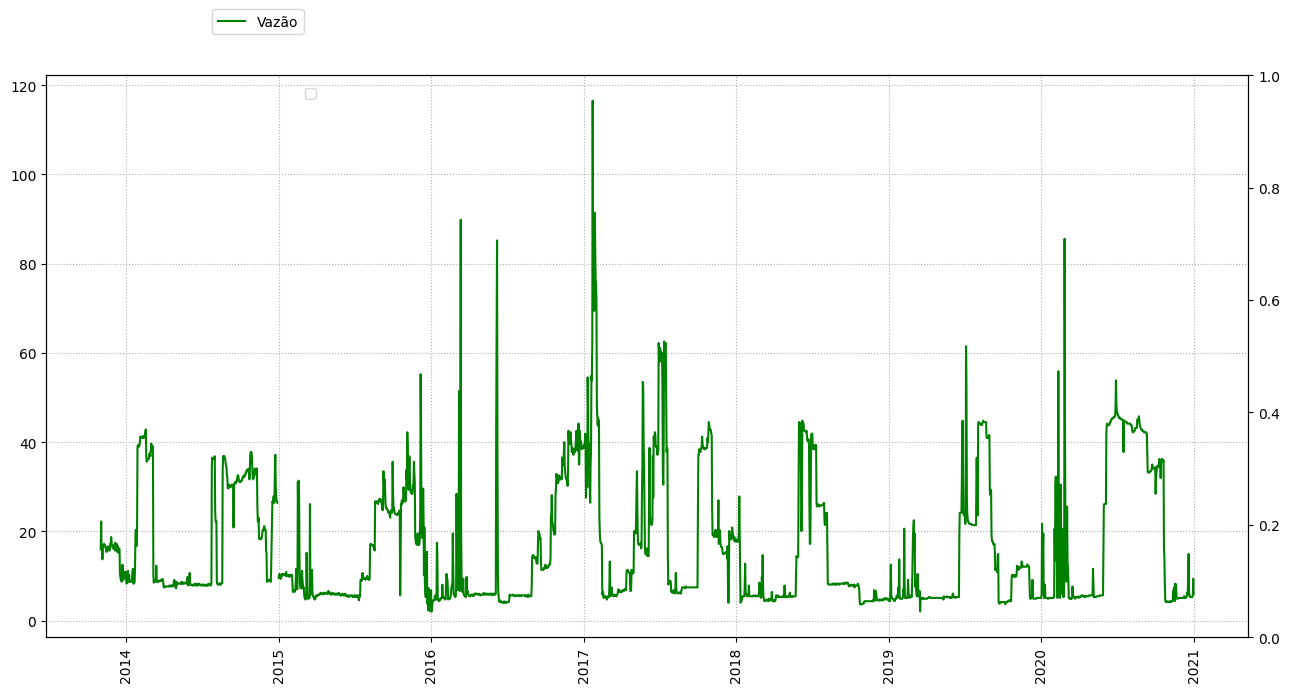

In [14]:
hidrograma(df_filtro)